In [ ]:
"""
Geographical Origin of Music - GP Regression & Classification
Author: Priyadharshini Nagarajan
"""

In [35]:
# 0. SETUP & IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, f1_score, confusion_matrix,
    classification_report
)
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

random_state = 42
np.random.seed(random_state)

In [36]:
# 1. LOAD DATASET

df_plus = pd.read_csv(
    "default_plus_chromatic_features_1059_tracks.txt",
    header=None,
    sep=","
)

print(f"Dataset shape: {df_plus.shape}")
print(f"Expected: (1059, 118)")

# Verify last two columns are lat/lon
print("\nLast 5 rows, last 2 columns:")
print(df_plus.iloc[-5:, -2:])


Dataset shape: (1059, 118)
Expected: (1059, 118)

Last 5 rows, last 2 columns:
        116     117
1054  -6.17   35.74
1055  11.55  104.91
1056  41.33   19.80
1057  54.68   25.31
1058  54.68   25.31


In [37]:
# 2. SEPARATE FEATURES AND TARGETS

X_full = df_plus.iloc[:, :-2].values
y_lat = df_plus.iloc[:, -2].values
y_lon = df_plus.iloc[:, -1].values

print(f"\nX shape: {X_full.shape}")
print(f"Latitude shape: {y_lat.shape}")
print(f"Longitude shape: {y_lon.shape}")



X shape: (1059, 116)
Latitude shape: (1059,)
Longitude shape: (1059,)


In [38]:
# 3. CREATE REGION LABELS FROM COORDINATES

def coord_to_region(lat, lon):
    """Map coordinates to macro-regions"""
    if -35 <= lat <= 70 and -20 <= lon <= 60:
        return "Europe_NorthAfrica"
    elif -10 <= lat <= 60 and 60 < lon <= 150:
        return "Asia"
    elif lon < -20 and -60 <= lat <= 70:
        return "Americas"
    elif lat < -10 and 110 <= lon <= 180:
        return "Oceania_South"
    else:
        return "Other"

regions = np.array([coord_to_region(la, lo) for la, lo in zip(y_lat, y_lon)])

# Check region distribution
unique_regions, counts = np.unique(regions, return_counts=True)
print("\nRegion distribution:")
for r, c in zip(unique_regions, counts):
    print(f"  {r}: {c}")

# Encode regions
le_region = LabelEncoder()
y_region = le_region.fit_transform(regions)

print(f"\nRegion encoding: {dict(zip(le_region.classes_, range(len(le_region.classes_))))}")



Region distribution:
  Americas: 103
  Asia: 353
  Europe_NorthAfrica: 589
  Oceania_South: 14

Region encoding: {np.str_('Americas'): 0, np.str_('Asia'): 1, np.str_('Europe_NorthAfrica'): 2, np.str_('Oceania_South'): 3}


In [39]:
# 4. TRAIN/VAL/TEST SPLIT (60/20/20)

# First split: train+temp (80%) vs test (20%)
X_train_temp, X_test, y_lat_train_temp, y_lat_test, \
y_lon_train_temp, y_lon_test, y_region_train_temp, y_region_test = \
train_test_split(
    X_full, y_lat, y_lon, y_region,
    test_size=0.2,
    random_state=random_state,
    stratify=y_region
)

# Second split: train (60%) vs val (20%)
X_train, X_val, y_lat_train, y_lat_val, \
y_lon_train, y_lon_val, y_region_train, y_region_val = \
train_test_split(
    X_train_temp, y_lat_train_temp, y_lon_train_temp, y_region_train_temp,
    test_size=0.25,  # 25% of 80% = 20% total
    random_state=random_state,
    stratify=y_region_train_temp
)

print(f"\nData split sizes:")
print(f"  Train: {X_train.shape[0]}")
print(f"  Val:   {X_val.shape[0]}")
print(f"  Test:  {X_test.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features standardized (fit on train, applied to val/test)")



Data split sizes:
  Train: 635
  Val:   212
  Test:  212
Features standardized (fit on train, applied to val/test)


In [41]:
# 5. BASELINE REGRESSION (Linear & Ridge)

print("BASELINE REGRESSION MODELS")

# Latitude - Linear Regression
lr_lat = LinearRegression()
lr_lat.fit(X_train_scaled, y_lat_train)
y_lat_pred_test_lr = lr_lat.predict(X_test_scaled)
rmse_lat_lr = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred_test_lr))
mae_lat_lr = mean_absolute_error(y_lat_test, y_lat_pred_test_lr)

print(f"\nLinear Regression (Latitude):")
print(f"  RMSE: {rmse_lat_lr:.4f}")
print(f"  MAE:  {mae_lat_lr:.4f}")

# Latitude - Ridge Regression
ridge_lat = Ridge(alpha=1.0)
ridge_lat.fit(X_train_scaled, y_lat_train)
y_lat_pred_test_ridge = ridge_lat.predict(X_test_scaled)
rmse_lat_ridge = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred_test_ridge))
mae_lat_ridge = mean_absolute_error(y_lat_test, y_lat_pred_test_ridge)

print(f"\nRidge Regression (Latitude):")
print(f"  RMSE: {rmse_lat_ridge:.4f}")
print(f"  MAE:  {mae_lat_ridge:.4f}")

# Longitude - Linear Regression
lr_lon = LinearRegression()
lr_lon.fit(X_train_scaled, y_lon_train)
y_lon_pred_test_lr = lr_lon.predict(X_test_scaled)
rmse_lon_lr = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred_test_lr))
mae_lon_lr = mean_absolute_error(y_lon_test, y_lon_pred_test_lr)

print(f"\nLinear Regression (Longitude):")
print(f"  RMSE: {rmse_lon_lr:.4f}")
print(f"  MAE:  {mae_lon_lr:.4f}")

# Longitude - Ridge Regression
ridge_lon = Ridge(alpha=1.0)
ridge_lon.fit(X_train_scaled, y_lon_train)
y_lon_pred_test_ridge = ridge_lon.predict(X_test_scaled)
rmse_lon_ridge = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred_test_ridge))
mae_lon_ridge = mean_absolute_error(y_lon_test, y_lon_pred_test_ridge)

print(f"\nRidge Regression (Longitude):")
print(f"  RMSE: {rmse_lon_ridge:.4f}")
print(f"  MAE:  {mae_lon_ridge:.4f}")


BASELINE REGRESSION MODELS

Linear Regression (Latitude):
  RMSE: 17.3072
  MAE:  13.2300

Ridge Regression (Latitude):
  RMSE: 17.1987
  MAE:  13.1542

Linear Regression (Longitude):
  RMSE: 43.4885
  MAE:  33.4159

Ridge Regression (Longitude):
  RMSE: 43.4114
  MAE:  33.3836


In [ ]:
# 6. BASELINE CLASSIFICATION (Logistic & Random Forest)

print("BASELINE CLASSIFICATION MODELS")

# Logistic Regression
lr_clf = LogisticRegression(max_iter=200, multi_class='auto', random_state=random_state)
lr_clf.fit(X_train_scaled, y_region_train)
y_region_pred_test_lr = lr_clf.predict(X_test_scaled)
acc_lr = accuracy_score(y_region_test, y_region_pred_test_lr)
f1_lr = f1_score(y_region_test, y_region_pred_test_lr, average='macro', zero_division=0)

print(f"\nLogistic Regression:")
print(f"  Accuracy: {acc_lr:.4f}")
print(f"  Macro-F1: {f1_lr:.4f}")

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20,
                                 random_state=random_state, n_jobs=-1)
rf_clf.fit(X_train_scaled, y_region_train)
y_region_pred_test_rf = rf_clf.predict(X_test_scaled)
acc_rf = accuracy_score(y_region_test, y_region_pred_test_rf)
f1_rf = f1_score(y_region_test, y_region_pred_test_rf, average='macro', zero_division=0)

print(f"\nRandom Forest:")
print(f"  Accuracy: {acc_rf:.4f}")
print(f"  Macro-F1: {f1_rf:.4f}")


In [44]:
# 7. GAUSSIAN PROCESS REGRESSION (RBF & Matérn)

print("GAUSSIAN PROCESS REGRESSION")

# Define kernels
kernel_rbf = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel_matern = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)

# GP-RBF Latitude
print("\nTraining GP-RBF (Latitude)...")
gpr_lat_rbf = GaussianProcessRegressor(
    kernel=kernel_rbf,
    alpha=1e-3,
    normalize_y=True,
    n_restarts_optimizer=2,
    random_state=random_state
)
gpr_lat_rbf.fit(X_train_scaled, y_lat_train)
y_lat_pred_gp_rbf, y_lat_std_gp_rbf = gpr_lat_rbf.predict(X_test_scaled, return_std=True)
rmse_lat_gp_rbf = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred_gp_rbf))
mae_lat_gp_rbf = mean_absolute_error(y_lat_test, y_lat_pred_gp_rbf)

print(f"GP-RBF (Latitude):")
print(f"  RMSE: {rmse_lat_gp_rbf:.4f}")
print(f"  MAE:  {mae_lat_gp_rbf:.4f}")

# GP-Matérn Latitude
print("\nTraining GP-Matérn (Latitude)...")
gpr_lat_matern = GaussianProcessRegressor(
    kernel=kernel_matern,
    alpha=1e-3,
    normalize_y=True,
    n_restarts_optimizer=2,
    random_state=random_state
)
gpr_lat_matern.fit(X_train_scaled, y_lat_train)
y_lat_pred_gp_matern, y_lat_std_gp_matern = gpr_lat_matern.predict(X_test_scaled, return_std=True)
rmse_lat_gp_matern = np.sqrt(mean_squared_error(y_lat_test, y_lat_pred_gp_matern))
mae_lat_gp_matern = mean_absolute_error(y_lat_test, y_lat_pred_gp_matern)

print(f"GP-Matérn (Latitude):")
print(f"  RMSE: {rmse_lat_gp_matern:.4f}")
print(f"  MAE:  {mae_lat_gp_matern:.4f}")

# GP-RBF Longitude
print("\nTraining GP-RBF (Longitude)...")
gpr_lon_rbf = GaussianProcessRegressor(
    kernel=kernel_rbf,
    alpha=1e-3,
    normalize_y=True,
    n_restarts_optimizer=2,
    random_state=random_state
)
gpr_lon_rbf.fit(X_train_scaled, y_lon_train)
y_lon_pred_gp_rbf, y_lon_std_gp_rbf = gpr_lon_rbf.predict(X_test_scaled, return_std=True)
rmse_lon_gp_rbf = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred_gp_rbf))
mae_lon_gp_rbf = mean_absolute_error(y_lon_test, y_lon_pred_gp_rbf)

print(f"GP-RBF (Longitude):")
print(f"  RMSE: {rmse_lon_gp_rbf:.4f}")
print(f"  MAE:  {mae_lon_gp_rbf:.4f}")

# GP-Matérn Longitude
print("\nTraining GP-Matérn (Longitude)...")
gpr_lon_matern = GaussianProcessRegressor(
    kernel=kernel_matern,
    alpha=1e-3,
    normalize_y=True,
    n_restarts_optimizer=2,
    random_state=random_state
)
gpr_lon_matern.fit(X_train_scaled, y_lon_train)
y_lon_pred_gp_matern, y_lon_std_gp_matern = gpr_lon_matern.predict(X_test_scaled, return_std=True)
rmse_lon_gp_matern = np.sqrt(mean_squared_error(y_lon_test, y_lon_pred_gp_matern))
mae_lon_gp_matern = mean_absolute_error(y_lon_test, y_lon_pred_gp_matern)

print(f"GP-Matérn (Longitude):")
print(f"  RMSE: {rmse_lon_gp_matern:.4f}")
print(f"  MAE:  {mae_lon_gp_matern:.4f}")


GAUSSIAN PROCESS REGRESSION

Training GP-RBF (Latitude)...
GP-RBF (Latitude):
  RMSE: 15.5642
  MAE:  11.4622

Training GP-Matérn (Latitude)...
GP-Matérn (Latitude):
  RMSE: 15.1987
  MAE:  11.0994

Training GP-RBF (Longitude)...
GP-RBF (Longitude):
  RMSE: 42.3594
  MAE:  32.4555

Training GP-Matérn (Longitude)...
GP-Matérn (Longitude):
  RMSE: 40.7482
  MAE:  31.2131


In [45]:
# 8. GAUSSIAN PROCESS CLASSIFICATION (RBF & Matérn)

print("GAUSSIAN PROCESS CLASSIFICATION")


# GP-RBF Classifier
print("\nTraining GP-RBF Classifier...")
kernel_rbf_clf = 1.0 * RBF(length_scale=1.0)
gp_clf_rbf = GaussianProcessClassifier(
    kernel=kernel_rbf_clf,
    max_iter_predict=100,
    random_state=random_state,
    n_restarts_optimizer=1,
    multi_class='one_vs_rest'
)
gp_clf_rbf.fit(X_train_scaled, y_region_train)
y_region_pred_test_gp_rbf = gp_clf_rbf.predict(X_test_scaled)
acc_gp_rbf = accuracy_score(y_region_test, y_region_pred_test_gp_rbf)
f1_gp_rbf = f1_score(y_region_test, y_region_pred_test_gp_rbf, average='macro', zero_division=0)

print(f"GP-RBF Classifier:")
print(f"  Accuracy: {acc_gp_rbf:.4f}")
print(f"  Macro-F1: {f1_gp_rbf:.4f}")

# GP-Matérn Classifier
print("\nTraining GP-Matérn Classifier...")
kernel_matern_clf = 1.0 * Matern(length_scale=1.0, nu=1.5)
gp_clf_matern = GaussianProcessClassifier(
    kernel=kernel_matern_clf,
    max_iter_predict=100,
    random_state=random_state,
    n_restarts_optimizer=1,
    multi_class='one_vs_rest'
)
gp_clf_matern.fit(X_train_scaled, y_region_train)
y_region_pred_test_gp_matern = gp_clf_matern.predict(X_test_scaled)
acc_gp_matern = accuracy_score(y_region_test, y_region_pred_test_gp_matern)
f1_gp_matern = f1_score(y_region_test, y_region_pred_test_gp_matern, average='macro', zero_division=0)

print(f"GP-Matérn Classifier:")
print(f"  Accuracy: {acc_gp_matern:.4f}")
print(f"  Macro-F1: {f1_gp_matern:.4f}")


GAUSSIAN PROCESS CLASSIFICATION

Training GP-RBF Classifier...
GP-RBF Classifier:
  Accuracy: 0.5660
  Macro-F1: 0.2253

Training GP-Matérn Classifier...
GP-Matérn Classifier:
  Accuracy: 0.6651
  Macro-F1: 0.3500


In [46]:
# 9. GEOGRAPHIC ERROR (HAVERSINE DISTANCE)

print("GEOGRAPHIC ERROR (HAVERSINE DISTANCE IN KM)")

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate great-circle distance in km"""
    R = 6371.0
    lat1_r, lon1_r = radians(lat1), radians(lon1)
    lat2_r, lon2_r = radians(lat2), radians(lon2)
    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r
    a = sin(dlat / 2)**2 + cos(lat1_r) * cos(lat2_r) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def mean_distance_error(lat_true, lon_true, lat_pred, lon_pred):
    distances = [haversine_distance(la_t, lo_t, la_p, lo_p)
                 for la_t, lo_t, la_p, lo_p in zip(lat_true, lon_true, lat_pred, lon_pred)]
    return np.mean(distances), np.std(distances)

# Best baseline (Ridge)
mean_dist_ridge, std_dist_ridge = mean_distance_error(
    y_lat_test, y_lon_test, y_lat_pred_test_ridge, y_lon_pred_test_ridge
)

# Best GP
mean_dist_gp_rbf, std_dist_gp_rbf = mean_distance_error(
    y_lat_test, y_lon_test, y_lat_pred_gp_rbf, y_lon_pred_gp_rbf
)

mean_dist_gp_matern, std_dist_gp_matern = mean_distance_error(
    y_lat_test, y_lon_test, y_lat_pred_gp_matern, y_lon_pred_gp_matern
)

print(f"\nRidge Regression: {mean_dist_ridge:.2f} ± {std_dist_ridge:.2f} km")
print(f"GP-RBF:          {mean_dist_gp_rbf:.2f} ± {std_dist_gp_rbf:.2f} km")
print(f"GP-Matérn:       {mean_dist_gp_matern:.2f} ± {std_dist_gp_matern:.2f} km")


GEOGRAPHIC ERROR (HAVERSINE DISTANCE IN KM)

Ridge Regression: 3806.97 ± 2656.06 km
GP-RBF:          3619.27 ± 2725.15 km
GP-Matérn:       3478.72 ± 2642.05 km


In [48]:
# 10. SUMMARY TABLES

print("SUMMARY TABLES")

# Regression Summary
reg_summary = pd.DataFrame({
    "Model": [
        "LinearReg (Lat)", "Ridge (Lat)", "GP-RBF (Lat)", "GP-Matérn (Lat)",
        "LinearReg (Lon)", "Ridge (Lon)", "GP-RBF (Lon)", "GP-Matérn (Lon)"
    ],
    "RMSE": [
        rmse_lat_lr, rmse_lat_ridge, rmse_lat_gp_rbf, rmse_lat_gp_matern,
        rmse_lon_lr, rmse_lon_ridge, rmse_lon_gp_rbf, rmse_lon_gp_matern
    ],
    "MAE": [
        mae_lat_lr, mae_lat_ridge, mae_lat_gp_rbf, mae_lat_gp_matern,
        mae_lon_lr, mae_lon_ridge, mae_lon_gp_rbf, mae_lon_gp_matern
    ]
})

print("\nREGRESSION RESULTS:")
print(reg_summary.to_string(index=False))

# Classification Summary
clf_summary = pd.DataFrame({
    "Model": [
        "Logistic Regression", "Random Forest",
        "GP-RBF", "GP-Matérn"
    ],
    "Accuracy": [
        acc_lr, acc_rf,
        acc_gp_rbf, acc_gp_matern
    ],
    "Macro-F1": [
        f1_lr, f1_rf,
        f1_gp_rbf, f1_gp_matern
    ]
})

print("\nCLASSIFICATION RESULTS:")
print(clf_summary.to_string(index=False))


SUMMARY TABLES

REGRESSION RESULTS:
          Model      RMSE       MAE
LinearReg (Lat) 17.307160 13.230025
    Ridge (Lat) 17.198725 13.154160
   GP-RBF (Lat) 15.564179 11.462188
GP-Matérn (Lat) 15.198727 11.099353
LinearReg (Lon) 43.488531 33.415858
    Ridge (Lon) 43.411380 33.383616
   GP-RBF (Lon) 42.359433 32.455523
GP-Matérn (Lon) 40.748187 31.213140

CLASSIFICATION RESULTS:
              Model  Accuracy  Macro-F1
Logistic Regression  0.655660  0.422950
      Random Forest  0.650943  0.345681
             GP-RBF  0.566038  0.225333
          GP-Matérn  0.665094  0.350022


GENERATING VISUALIZATIONS


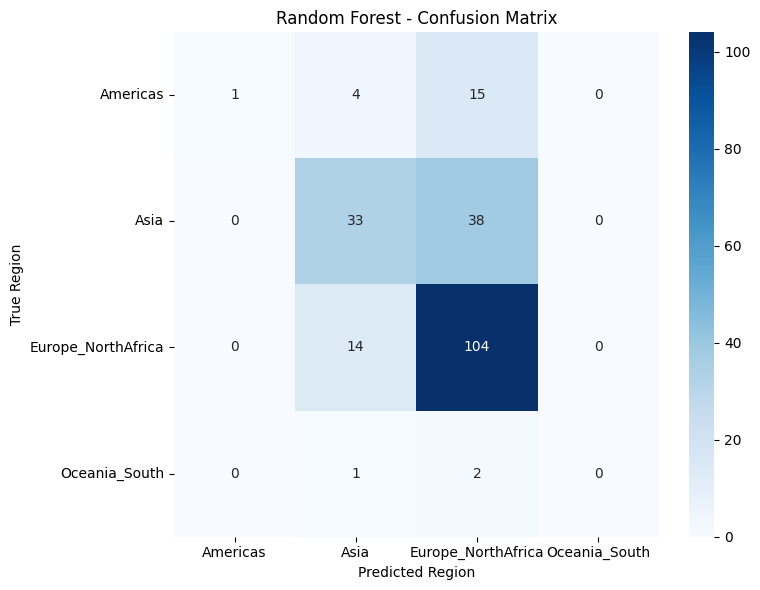

In [49]:
# 11. VISUALIZATIONS

print("GENERATING VISUALIZATIONS")

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_region_test, y_region_pred_test_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_region.classes_,
            yticklabels=le_region.classes_)
plt.xlabel("Predicted Region")
plt.ylabel("True Region")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig("cm_rf.png", dpi=100, bbox_inches='tight')
plt.show()



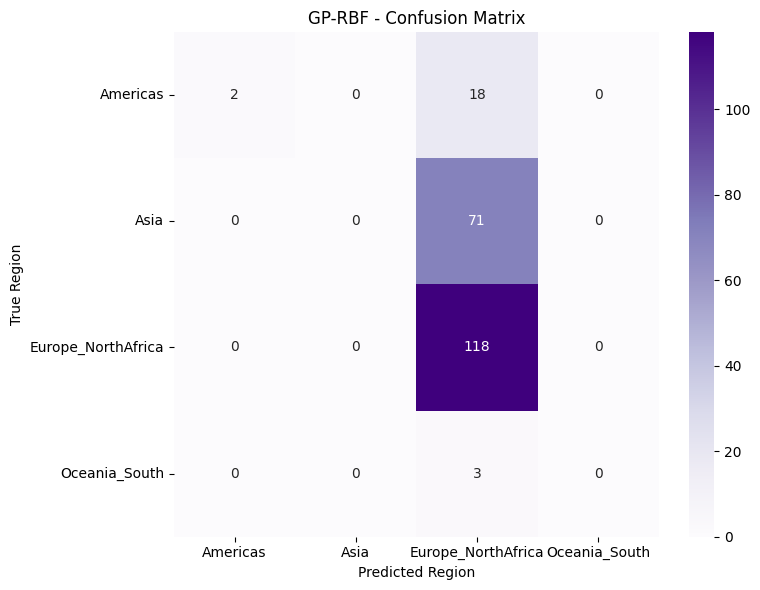

In [50]:
# Confusion Matrix - GP-RBF
cm_gp = confusion_matrix(y_region_test, y_region_pred_test_gp_rbf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gp, annot=True, fmt="d", cmap="Purples",
            xticklabels=le_region.classes_,
            yticklabels=le_region.classes_)
plt.xlabel("Predicted Region")
plt.ylabel("True Region")
plt.title("GP-RBF - Confusion Matrix")
plt.tight_layout()
plt.savefig("cm_gp_rbf.png", dpi=100, bbox_inches='tight')
plt.show()


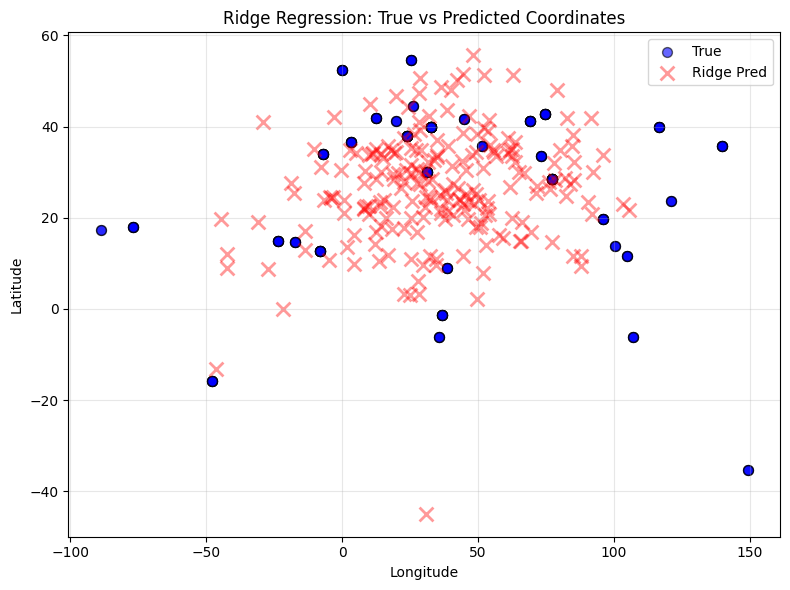

In [52]:
# True vs Predicted Coordinates (Ridge)
plt.figure(figsize=(8, 6))
plt.scatter(y_lon_test, y_lat_test, c="blue", alpha=0.6, label="True", s=50, edgecolors='k')
plt.scatter(y_lon_pred_test_ridge, y_lat_pred_test_ridge, c="red", alpha=0.4,
            label="Ridge Pred", marker="x", s=100, linewidths=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ridge Regression: True vs Predicted Coordinates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("coords_ridge.png", dpi=100, bbox_inches='tight')
plt.show()


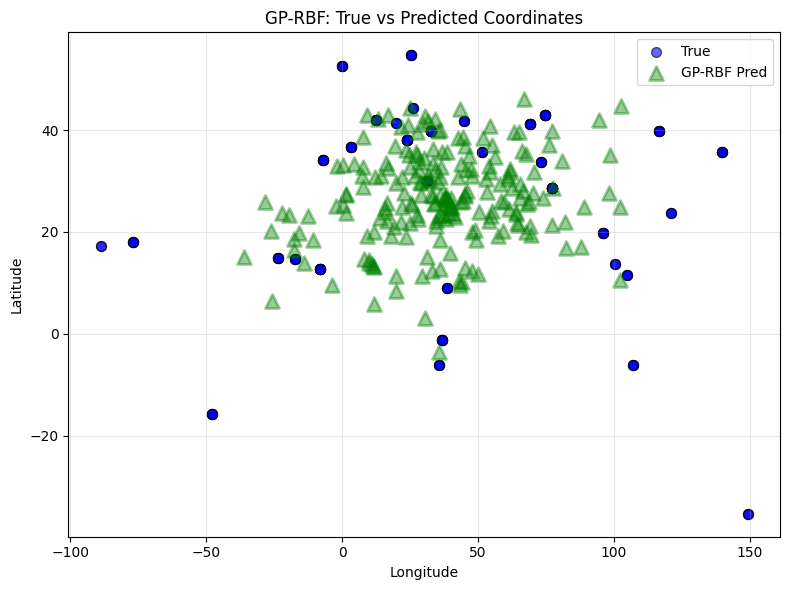

In [53]:
# True vs Predicted Coordinates (GP-RBF)
plt.figure(figsize=(8, 6))
plt.scatter(y_lon_test, y_lat_test, c="blue", alpha=0.6, label="True", s=50, edgecolors='k')
plt.scatter(y_lon_pred_gp_rbf, y_lat_pred_gp_rbf, c="green", alpha=0.4,
            label="GP-RBF Pred", marker="^", s=100, linewidths=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GP-RBF: True vs Predicted Coordinates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("coords_gp_rbf.png", dpi=100, bbox_inches='tight')
plt.show()

GP UNCERTAINTY SAMPLE (LATITUDE)

True Lat | Predicted Lat | ±2σ Interval
---------------------------------------------
  30.03 |         38.50 | [   9.48,   67.53]
  39.91 |         30.69 | [  -2.85,   64.24]
  54.68 |         41.78 | [   4.94,   78.61]
  41.33 |         29.36 | [  -4.56,   63.28]
  35.70 |         44.79 | [  15.57,   74.01]
  52.50 |         36.10 | [  -2.41,   74.60]
  39.91 |         28.04 | [  -7.65,   63.72]
  12.65 |         10.20 | [ -17.43,   37.84]
  52.50 |         42.24 | [   6.92,   77.57]
  -6.17 |         23.20 | [ -13.16,   59.55]
 -15.75 |          6.37 | [ -22.34,   35.07]
 -35.30 |         22.04 | [ -13.89,   57.98]
  41.71 |         34.73 | [  -3.39,   72.85]
  33.66 |         15.87 | [ -15.05,   46.80]
  35.68 |         30.82 | [  -2.62,   64.25]


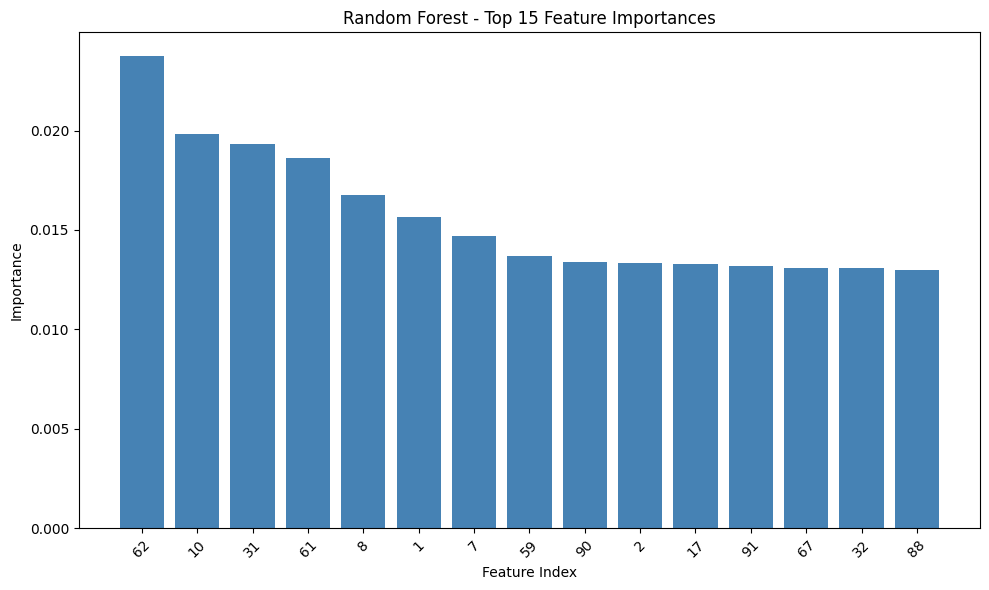


Top 5 features: [62 10 31 61  8]
Top 5 importances: [0.02374895 0.01982959 0.01930027 0.01860898 0.0167535 ]


In [55]:
# GP Uncertainty Sample (Latitude)
print("GP UNCERTAINTY SAMPLE (LATITUDE)")

idx_sample = np.random.choice(len(y_lat_test), size=15, replace=False)
print("\nTrue Lat | Predicted Lat | ±2σ Interval")
print("-" * 45)
for i in idx_sample:
    true_val = y_lat_test[i]
    pred_val = y_lat_pred_gp_rbf[i]
    std_val = y_lat_std_gp_rbf[i]
    print(f"{true_val:7.2f} | {pred_val:13.2f} | [{pred_val-2*std_val:7.2f}, {pred_val+2*std_val:7.2f}]")

# Feature Importance (Random Forest)
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
top_k = 15

plt.figure(figsize=(10, 6))
plt.bar(range(top_k), importances[indices[:top_k]], align="center", color="steelblue")
plt.xticks(range(top_k), indices[:top_k], rotation=45)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Random Forest - Top 15 Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=100, bbox_inches='tight')
plt.show()

print(f"\nTop 5 features: {indices[:5]}")
print(f"Top 5 importances: {importances[indices[:5]]}")


In [61]:
# 12. EXPORT RESULTS TO CSV

print("EXPORTING RESULTS")

# Export summary tables
reg_summary.to_csv("regression_results.csv", index=False)
clf_summary.to_csv("classification_results.csv", index=False)

print("\nResults exported to CSV files:")
print("  - regression_results.csv")
print("  - classification_results.csv")

# Export predictions for manual analysis
pred_df = pd.DataFrame({
    "true_lat": y_lat_test,
    "pred_lat_ridge": y_lat_pred_test_ridge,
    "pred_lat_gp_rbf": y_lat_pred_gp_rbf,
    "pred_lat_gp_matern": y_lat_pred_gp_matern,
    "true_lon": y_lon_test,
    "pred_lon_ridge": y_lon_pred_test_ridge,
    "pred_lon_gp_rbf": y_lon_pred_gp_rbf,
    "pred_lon_gp_matern": y_lon_pred_gp_matern,
    "true_region": le_region.inverse_transform(y_region_test),
    "pred_region_rf": le_region.inverse_transform(y_region_pred_test_rf),
    "pred_region_gp_rbf": le_region.inverse_transform(y_region_pred_test_gp_rbf),
})

pred_df.to_csv("detailed_predictions.csv", index=False)
print("  - detailed_predictions.csv")

print("ANALYSIS COMPLETE!")

print("\nFiles generated:")
print("  - cm_rf.png")
print("  - cm_gp_rbf.png")
print("  - coords_ridge.png")
print("  - coords_gp_rbf.png")
print("  - feature_importance.png")
print("  - regression_results.csv")
print("  - classification_results.csv")
print("  - detailed_predictions.csv")


EXPORTING RESULTS

Results exported to CSV files:
  - regression_results.csv
  - classification_results.csv
  - detailed_predictions.csv
ANALYSIS COMPLETE!

Files generated:
  - cm_rf.png
  - cm_gp_rbf.png
  - coords_ridge.png
  - coords_gp_rbf.png
  - feature_importance.png
  - regression_results.csv
  - classification_results.csv
  - detailed_predictions.csv
